In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
conda create --name cnn

Solving environment: done

## Package Plan ##

  environment location: /Users/james/opt/anaconda3/envs/cnn



Proceed ([y]/n)? ^C

CondaSystemExit: 
Operation aborted.  Exiting.


Note: you may need to restart the kernel to use updated packages.


In [3]:
conda activate cnn


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.



Note: you may need to restart the kernel to use updated packages.


In [4]:
conda install pytorch torchvision -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /Users/james/opt/anaconda3

  added / updated specs:
    - pytorch
    - torchvision


The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2022.12.~ --> pkgs/main::ca-certificates-2023.01.10-hca03da5_0 

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2022.12.7~ --> pkgs/main/osx-arm64::certifi-2022.12.7-py39hca03da5_0 
  openssl            conda-forge::openssl-1.1.1t-h03a7124_0 --> pkgs/main::openssl-1.1.1t-h1a28f6b_0 




Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [5]:
conda install -c conda-forge jupyterlab

Solving environment: done

## Package Plan ##

  environment location: /Users/james/opt/anaconda3

  added / updated specs:
    - jupyterlab


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2023.01.10~ --> conda-forge::ca-certificates-2022.12.7-h4653dfc_0 
  certifi            pkgs/main/osx-arm64::certifi-2022.12.~ --> conda-forge/noarch::certifi-2022.12.7-pyhd8ed1ab_0 
  openssl              pkgs/main::openssl-1.1.1t-h1a28f6b_0 --> conda-forge::openssl-1.1.1t-h03a7124_0 




Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
base_dir = '/Users/james/Desktop/Cancerdetection-CNN'
print(os.listdir(base_dir))

# Matplotlib for visualization
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# OpenCV Image Library
import cv2

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

# Import useful sklearn functions
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image

['train_labels.csv', '.DS_Store', 'test', 'train', 'sample_submission.csv']


# Loading Data and EDA
Having a look at the data, just like any other image classification problem we have a csv file with image ids and labels. The directories train, test contain the actual images.

In [7]:
full_train_df = pd.read_csv("/Users/james/Desktop/Cancerdetection-CNN/train_labels.csv")
full_train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [8]:
print("Train Size: {}".format(len(os.listdir('/Users/james/Desktop/Cancerdetection-CNN/train'))))
print("Test Size: {}".format(len(os.listdir('/Users/james/Desktop/Cancerdetection-CNN/test'))))

Train Size: 220026
Test Size: 57458


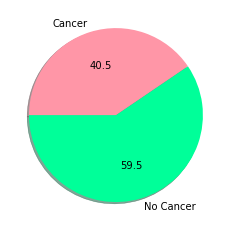

<Figure size 1152x1152 with 0 Axes>

In [9]:
labels_count = full_train_df.label.value_counts()

%matplotlib inline
plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=180, 
        autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=True)
plt.figure(figsize=(16,16))
plt.show()

# Visualizing Images
Classifying metastases is probably not an easy task for a trained pathologist and extremely difficult for an untrained eye when we take a look at the image.

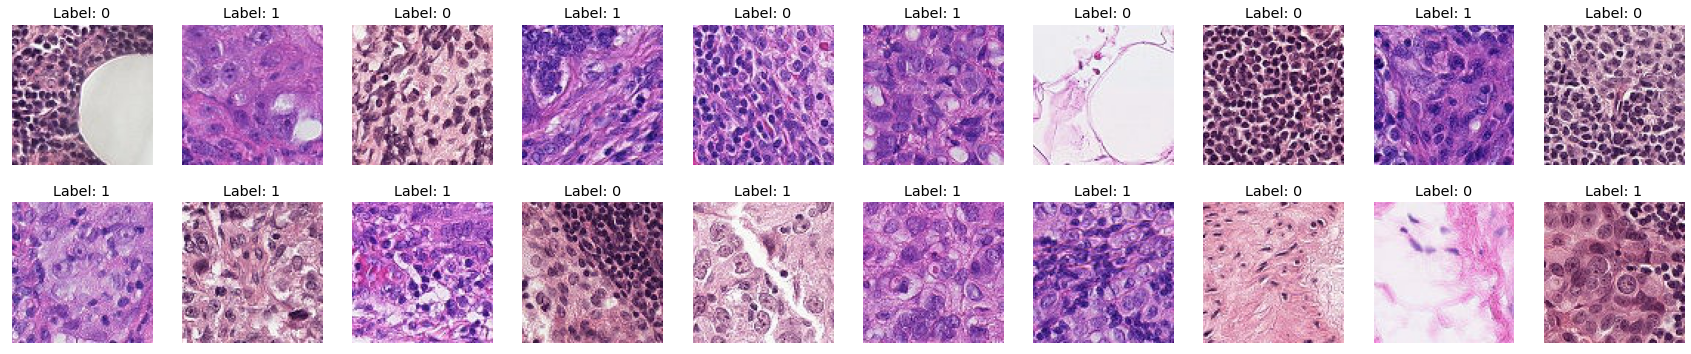

In [10]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(base_dir+"/train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train/" + img)
    plt.imshow(im)
    lab = full_train_df.loc[full_train_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

# Sampling
Since the train dataset contains 220.025 images we can sample out a shuffled part of that, in this case 160000 samples and train on them to make predictions later. 

In [11]:
# Number of samples in each class
SAMPLE_SIZE = 80000

# Data paths
train_path = '/Users/james/Desktop/Cancerdetection-CNN/train'
test_path = '/Users/james/Desktop/Cancerdetection-CNN/test'

# Use 80000 positive and negative examples
df_negatives = full_train_df[full_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = full_train_df[full_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

train_df.shape

(160000, 2)

# Data Pre-processing for our PyTorch
First we turn our data into PyTorch dataset then the data is sampled into train and validation sets. Data Augmentations are added for train data to improve performance.

In [12]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [13]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    # We the get the following mean and std for the channels of all the images
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

In [14]:
# Set Batch Size
batch_size = 128

# Percentage of training set to use as validation
valid_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
print(train_data)

In [15]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# creating test data
sample_sub = pd.read_csv("/Users/james/Desktop/Cancerdetection-CNN/sample_submission.csv")
test_data = CreateDataset(df_data=sample_sub, data_dir=test_path, transform=transforms_test)

# prepare the test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Defining Model Architecture
I'm using a Deep Convolutional Neural Network for this task building which is fairly straight-forward in PyTorch if you understand how it works. This is one of many architectures I tried that gave better results.

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv5=nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        
        self.dropout2d = nn.Dropout2d()
        
        
        self.fc=nn.Sequential(
                nn.Linear(512*3*3,1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(1024,512),
                nn.Dropout(0.4),
                nn.Linear(512, 1),
                nn.Sigmoid())
        
    def forward(self,x):
        """Method for Forward Prop"""
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        #print(x.shape) <-- Life saving debugging step :D
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [17]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


# Training and Validation

In [18]:
# create a complete CNN
model = CNN()
print(model)

# Move model to GPU if available
if train_on_gpu: model.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [19]:
# Trainable Parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6805249


In [20]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.BCELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [21]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf

# keeping track of losses as it happen
train_losses = []
valid_losses = []
val_auc = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1)
        target = target.float()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        output = output.float()
    # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)

    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1)
        target = target.float()
        output = model(data)
        output = output.float()
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        #output = output.topk()
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))        
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))
    
    ##################
    # Early Stopping #
    ##################
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 | Training Loss: 0.364540 | Validation Loss: 0.332027 | Validation AUC: 0.9428
Validation loss decreased (inf --> 0.332027).  Saving model ...
Epoch: 2 | Training Loss: 0.296576 | Validation Loss: 0.321456 | Validation AUC: 0.9475
Validation loss decreased (0.332027 --> 0.321456).  Saving model ...
Epoch: 3 | Training Loss: 0.264635 | Validation Loss: 0.245728 | Validation AUC: 0.9533
Validation loss decreased (0.321456 --> 0.245728).  Saving model ...
Epoch: 4 | Training Loss: 0.240640 | Validation Loss: 0.229029 | Validation AUC: 0.9576
Validation loss decreased (0.245728 --> 0.229029).  Saving model ...
Epoch: 5 | Training Loss: 0.222853 | Validation Loss: 0.217273 | Validation AUC: 0.9612
Validation loss decreased (0.229029 --> 0.217273).  Saving model ...
Epoch: 6 | Training Loss: 0.209205 | Validation Loss: 0.243626 | Validation AUC: 0.9634
Epoch: 7 | Training Loss: 0.199060 | Validation Loss: 0.211643 | Validation AUC: 0.9654
Validation loss decreased (0.217273 --> 0.21

#### %matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

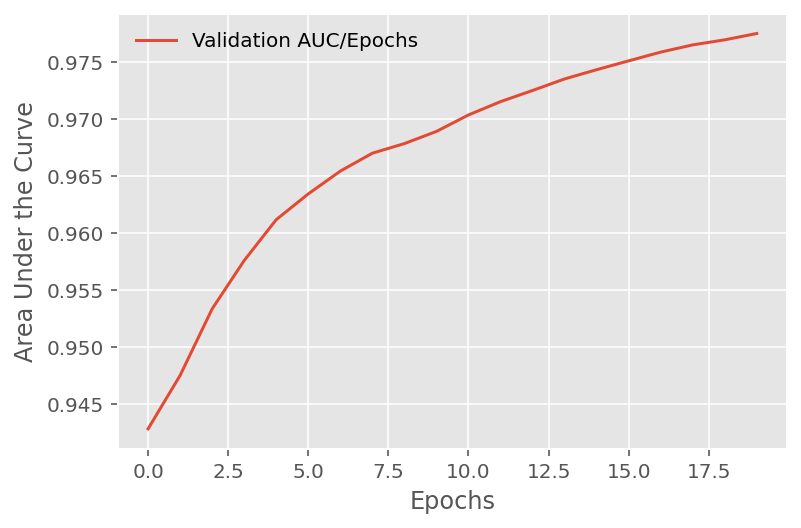

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(auc_epoch, label='Validation AUC/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Area Under the Curve")
plt.legend(frameon=False)

In [23]:
# Load Best parameters learned from training into our model to make predictions later
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

# Predictions on Test set

In [24]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.13.1
False


In [25]:
device = torch.device("mps")

In [26]:
# Turn off gradients
model.eval()
model=model.to(device)
preds = []
for batch_i, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)

    pr = output.detach().cpu().numpy()
    for i in pr:
        preds.append(i)

# Create Submission file        
sample_sub['label'] = preds

In [27]:
for i in range(len(sample_sub)):
    sample_sub.label[i] = np.float(sample_sub.label[i]) 

/var/folders/pr/0j1xfpyd3fs_ngsn3mvt0l080000gn/T/ipykernel_10403/16086037.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_sub.label[i] = np.float(sample_sub.label[i])


In [28]:
sample_sub.to_csv('submission.csv', index=False)
sample_sub.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.008254
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.32149
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.007706
3,2c35657e312966e9294eac6841726ff3a748febf,0.006455
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.030604


# Visualizing Preditions:

In [29]:
def imshow(img):
    '''Helper function to un-normalize and display an image'''
    # unnormalize
    img = img / 2 + 0.5
    # convert from Tensor image and display
    plt.imshow(np.transpose(img, (1, 2, 0)))

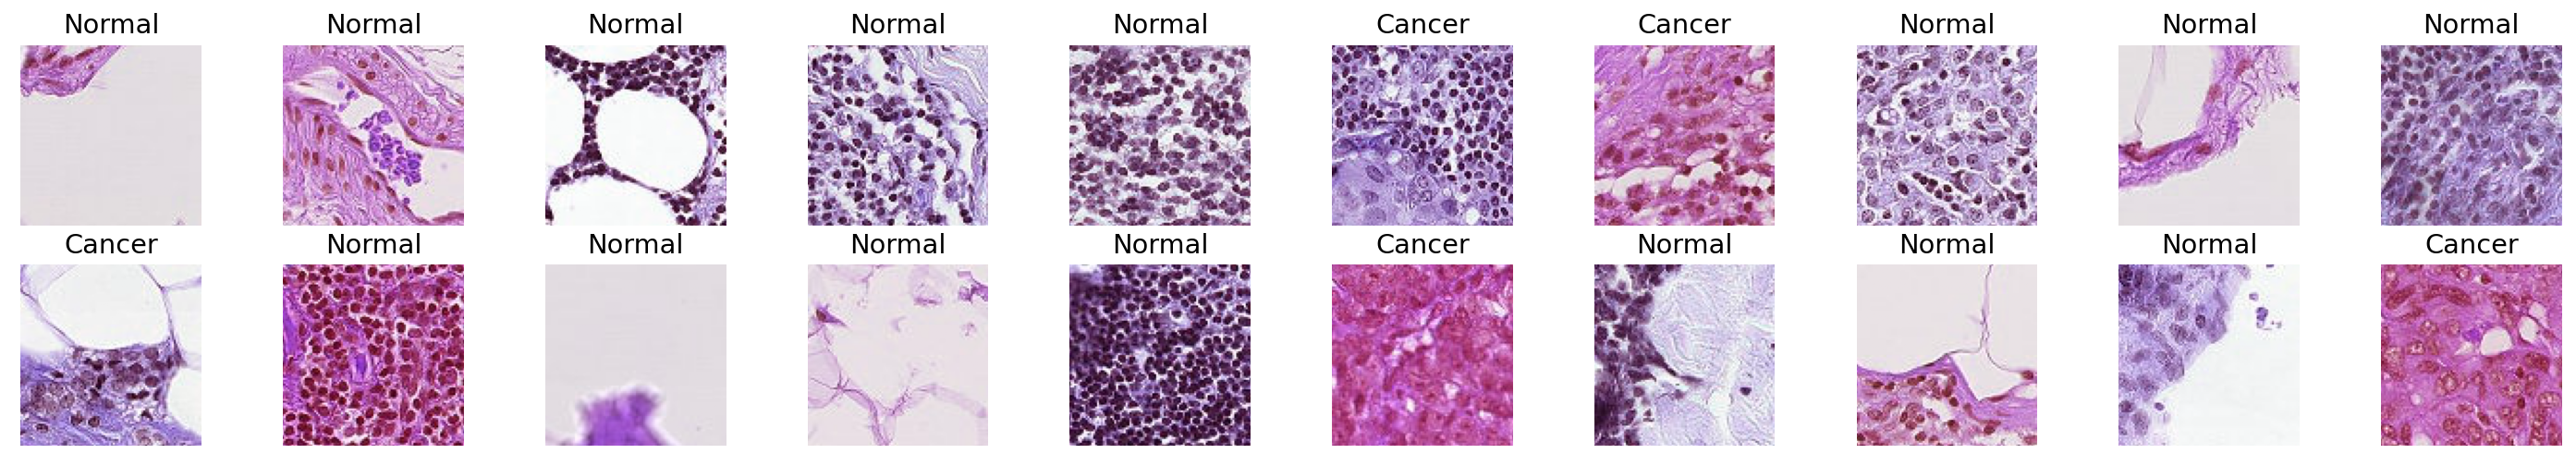

In [30]:
# obtain one batch of training images
dataiter = iter(test_loader)
images, labels = next (dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    prob = "Cancer" if(sample_sub.label[idx] >= 0.5) else "Normal" 
    ax.set_title('{}'.format(prob))